In [1]:
import pandas as pd , numpy as np
import os, torch, cv2, random
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from glob import glob
from torchvision import transforms as T
from PIL import Image

In [2]:
import glob
class CustomDataset(Dataset):
    def __init__(self, root,  transformations = None):
        super(). __init__()
        self.im_path = glob.glob(f"{root}/*/*/*")
        self.transformations = transformations
        self.class_names ={}
        count = 0
        for idx, paths in enumerate(self.im_path):
            image = self.get_class_name(paths)
            if image not in self.class_names:
                self.class_names[image] = count
                count+=1
    
    def get_class_name(self, path):
        return os.path.basename(path).split("_")[-2]

    def __len__(self): return len(self.im_path)
    def __getitem__(self, idx):
        ims = self.im_path[idx]
        im = Image.open(ims).convert("RGB")
        gt = self.class_names[self.get_class_name(ims)]
        if self.transformations is not None: im = self.transformations(im)
        return im, gt
mean, std =[0.2250, 0.2250, 0.2250], [0.2505, 0.2505, 0.2505]
transformer = T.Compose([T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(mean = mean, std = std)])
root = "Image-level annotation/Image-level annotation"
ds = CustomDataset(root =root, transformations = transformer )
classes = ds.class_names
classes
ds[0]

(tensor([[[1.1213, 1.1056, 1.1369,  ..., 1.4657, 1.4657, 1.4970],
          [1.0900, 1.0900, 1.1213,  ..., 1.4500, 1.4344, 1.4344],
          [1.0900, 1.0900, 1.1213,  ..., 1.4657, 1.4814, 1.4657],
          ...,
          [0.1037, 0.1037, 0.0881,  ..., 0.1820, 0.1507, 0.0881],
          [0.1194, 0.0881, 0.0567,  ..., 0.1350, 0.1507, 0.1976],
          [0.1037, 0.0411, 0.0411,  ..., 0.2133, 0.2133, 0.2133]],
 
         [[1.1369, 1.1213, 1.1369,  ..., 1.3405, 1.3405, 1.3718],
          [1.1056, 1.1056, 1.1213,  ..., 1.3248, 1.3091, 1.3091],
          [1.1056, 1.1056, 1.1213,  ..., 1.3405, 1.3561, 1.3405],
          ...,
          [0.1820, 0.1820, 0.1663,  ..., 0.1820, 0.1507, 0.0881],
          [0.1976, 0.1663, 0.1350,  ..., 0.1350, 0.1507, 0.1976],
          [0.1820, 0.1194, 0.1194,  ..., 0.2133, 0.2133, 0.2133]],
 
         [[1.0430, 1.0274, 1.0430,  ..., 1.1683, 1.1683, 1.1996],
          [1.0117, 1.0117, 1.0274,  ..., 1.1526, 1.1369, 1.1369],
          [1.0117, 1.0117, 1.0274,  ...,

In [3]:
tottal = len(ds)
split = [0.9, 0.05, 0.05]
tr_len = int(tottal*split[0])
val_len = int(tottal*split[1])
ts_len = tottal - (tr_len + val_len)
# splitting a dataset into training, validation, and test sets
tr_ds, val_ds, ts_ds = random_split(dataset=ds, lengths= [tr_len, val_len, ts_len])
print(f"Train dataset   -> {len(tr_ds)}")
print(f"Valid dataset   -> {len(val_ds)}")
print(f"Test  dataset   -> {len(ts_ds)}\n")

##  Create  DataLoaders
bs =64
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True,  num_workers = 0)
val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False,  num_workers = 0)
ts_dl = DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False,  num_workers = 0)
print(f"Train Dataloader dataset   -> {len(tr_dl)}")
print(f"Valid Dataloader dataset   -> {len(val_dl)}")
print(f"Test  Dataloader dataset   -> {len(ts_dl)}")


Train dataset   -> 33832
Valid dataset   -> 1879
Test  dataset   -> 1881

Train Dataloader dataset   -> 529
Valid Dataloader dataset   -> 30
Test  Dataloader dataset   -> 1881


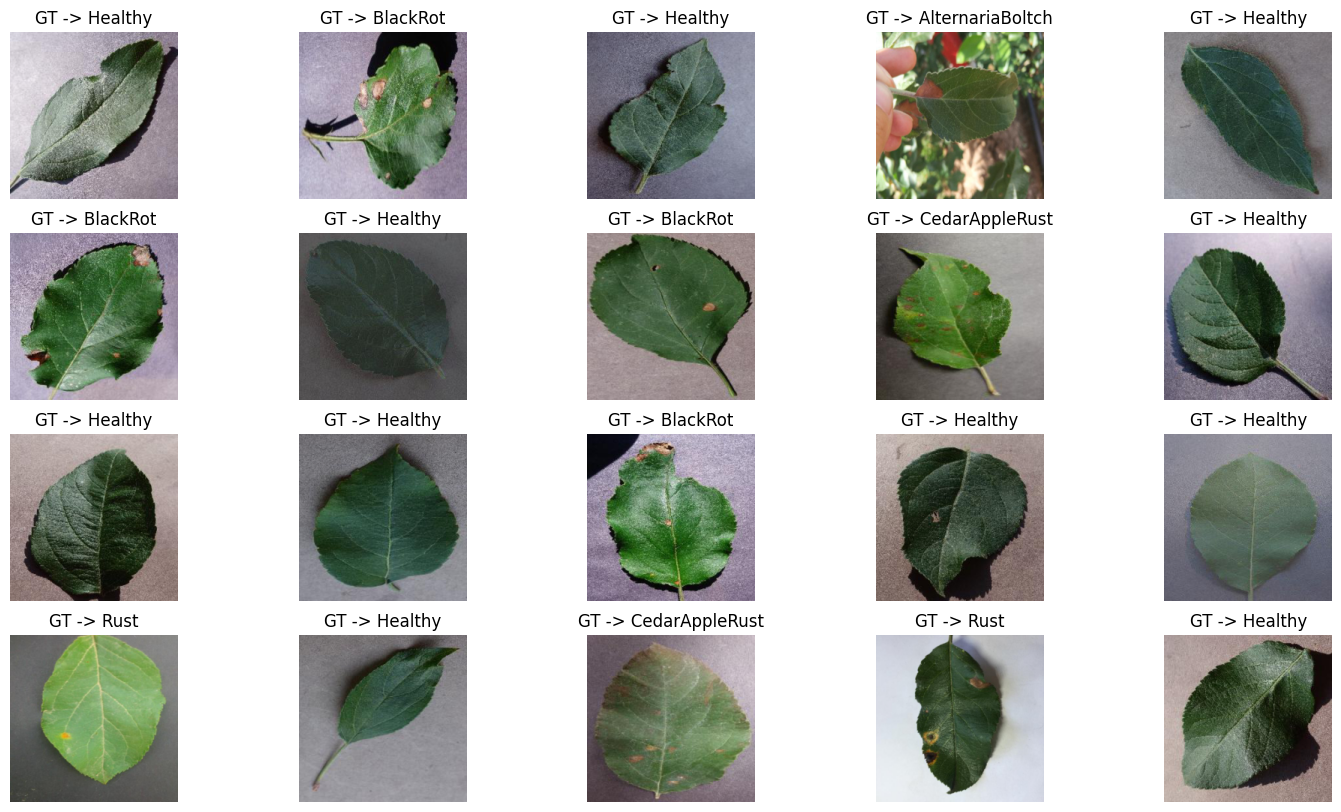

In [33]:
def tr_2_im(t, type = "rgb"):
    gray = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.2505, 1/0.2505, 1/0.2505]),
                         T.Normalize(mean = [ -0.2250, -0.2250, -0.2250 ], std = [ 1., 1., 1. ])])
    inp = gray if type == "gray" else rgb
    return(inp(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if type == "gray" else (inp(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, num_im, rows, cmap =None, class_name =None):
    assert cmap in ["rgb", "gray"]
    if cmap == "rgb": cmap = "RdBu"
    plt.figure(figsize=(18, 10))
    index = [random.randint(0, len(data)-1) for _ in range(num_im)]
    for i, idx in enumerate(index):
        im, gt = data[idx]
        plt.subplot(rows, num_im//rows, i+1)
        plt.imshow(tr_2_im(im, cmap), cmap="RdBu")
        plt.imshow(tr_2_im(im))
        plt.axis("off")
        plt.title(f"GT -> {class_name[gt]}")
visualize(data=tr_dl.dataset, num_im= 20, rows=4, cmap = 'rgb', class_name=list(classes.keys()))

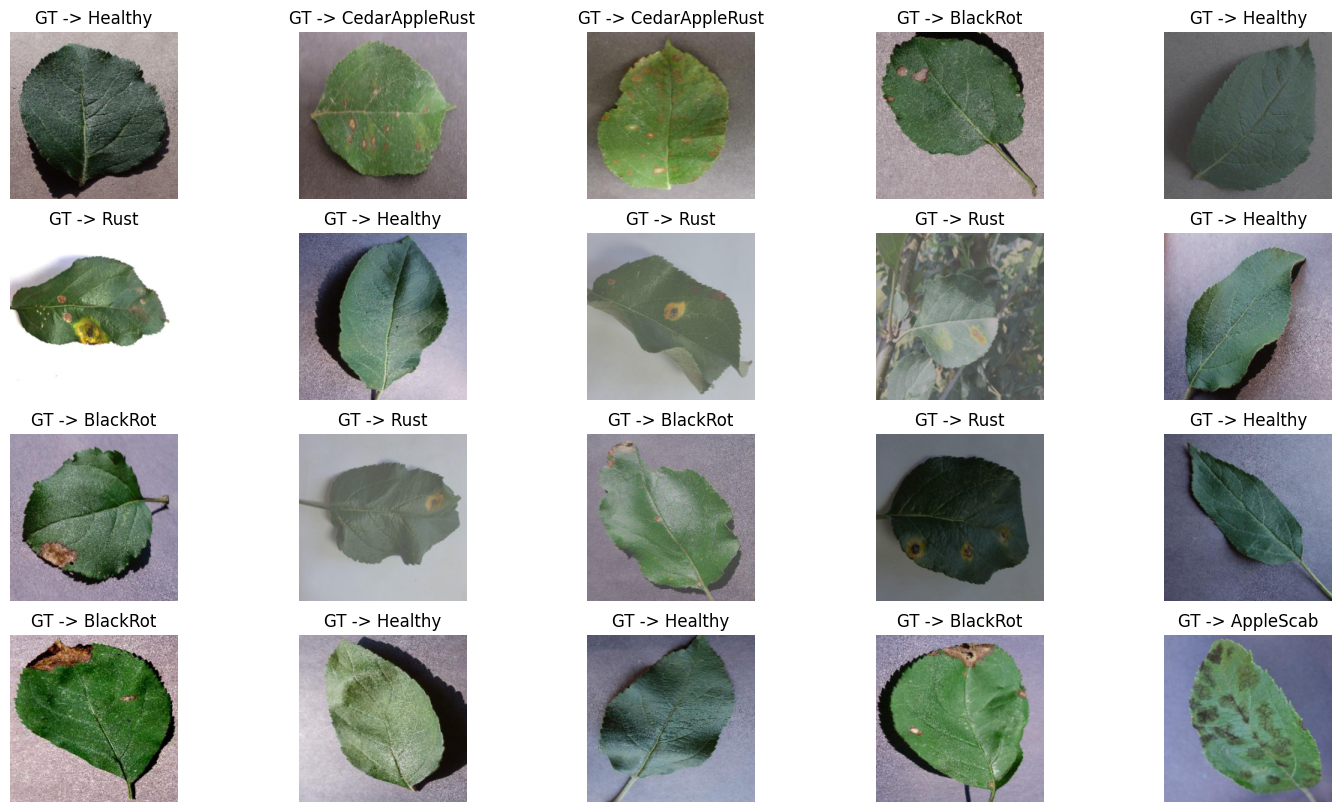

In [5]:
visualize(data=val_dl.dataset, num_im= 20, rows=4, cmap = 'rgb', class_name=list(classes.keys()))


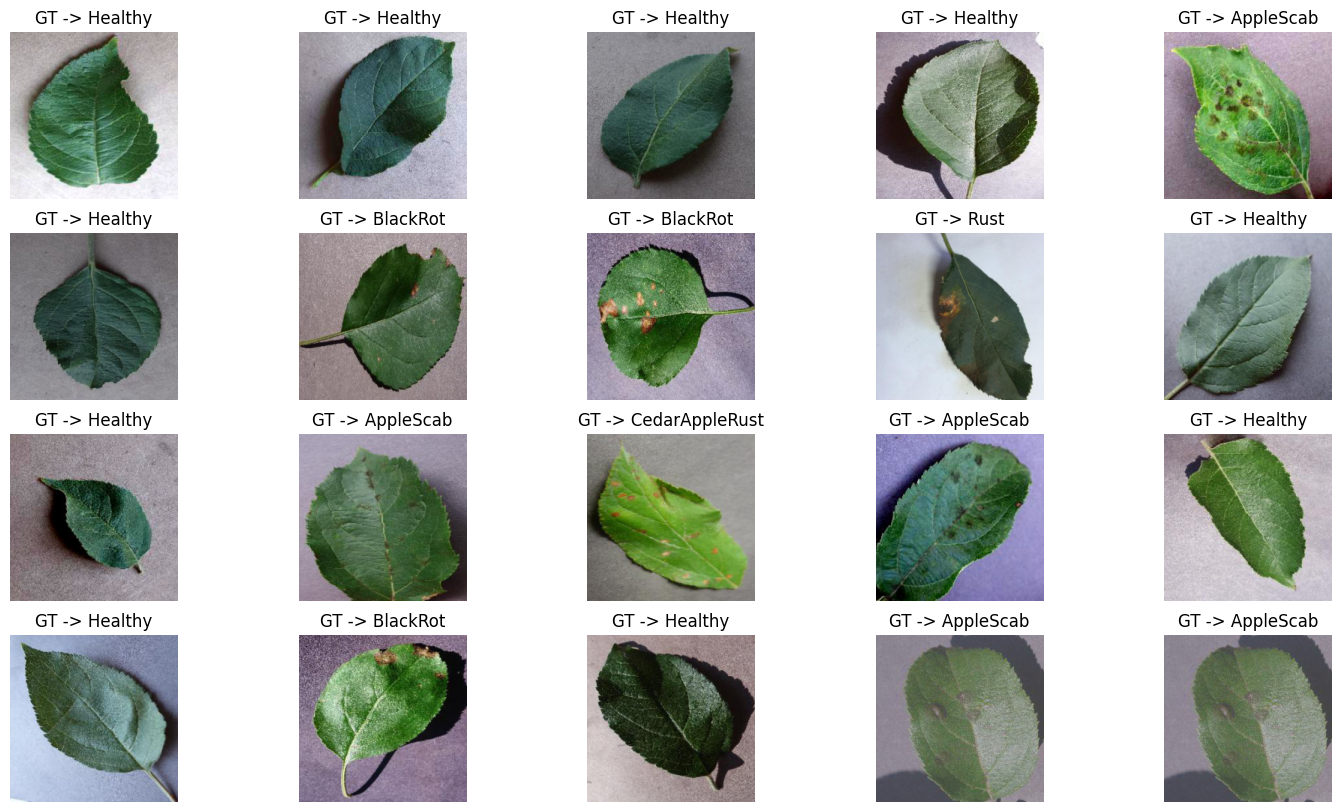

In [6]:
visualize(data=ts_dl.dataset, num_im= 20, rows=4, cmap = 'rgb', class_name=list(classes.keys()))


In [12]:
import timm
model = timm.create_model(model_name="rexnet_150", pretrained=True, num_classes = len(classes) )
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
model

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [8]:
from tqdm import tqdm
def train(model, tr, val, epochs, opt, loss_fn, device, threshold, save_prefix ):
    tr_loss, tr_acc , val_loss, val_acc = [],[],[],[]
    best_loss = np.inf
    for epoch in range(epochs):
        print(f"{epoch+1} - epoch is starting .....")
        tr_loss_, tr_acc_ , tr_total = 0,0,0
                
        for idx, batch in enumerate(tqdm(tr)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            #prediction using model
            pred = model(im)
            # culculate loss using loss function
            loss = loss_fn(pred, gt)
            #update the training loss
            tr_loss_+=loss.item()
            # get indeces of the maximum values in predictions
            pred_class = torch.argmax(pred, dim=1)
            # Culculate the train accura
            cy scores
            tr_acc_+= (pred_class==gt).sum().item()
            
            # preform optimizetion steps
            opt.zero_grad()
            loss.backward()
            opt.step()
        tr_loss_ /= len(tr)
        tr_acc_ /= len(tr.dataset)
        tr_loss.append(tr_loss_)
        tr_acc.append(tr_acc_)
       # Validation progress
       # set the model to Evalution mode
        model.eval()
        # Perform inference or validation without computing gradients
        with torch.no_grad():
            val_loss_, val_acc_ = 0,0
            for idx, batch in enumerate(tqdm(val)):
                im, gt =batch
                im, gt = im.to(device), gt.to(device)
                #predict using the model
                pred = model(im)
                # Culculate the loss using loss function
                loss = loss_fn(pred, gt)
                # update validation loss
                val_loss_+=loss.item()
                # get indeces of the maximum values in predictions
                pred_class = torch.argmax(pred, dim =1)
                # Culculate the validation accuracy scores
                val_acc_+=(pred_class == gt).sum().item()
                
            val_acc_ /=len(val.dataset)
            val_loss_ /= len(val)
            val_acc.append(val_acc_)
            val_loss.append(val_loss_)

            
            print(f"{epoch+1} - epoc Train process is results:\n")
            print(f"{epoch+1} - epoc Train Accuracy score       - > {tr_acc_:.3f}")
            print(f"{epoch+1} - epoc Train epoc loss  score      - > {tr_loss_:.3f}")
            print(f"{epoch+1} - epoc Validation process is results:\n")
            print(f"{epoch+1} - epoc Validation Accuracy score  - > {val_acc_:.3f}")
            print(f"{epoch+1} - epoc Validation epoc loss  score - > {val_loss_:.3f}")
            
            if val_loss_ < (best_loss + threshold):
                val_loss_ = best_loss
                os.makedirs("Apple_best_mode", exist_ok= True)
                torch.save(model, f"Apple_best_mode/{save_prefix}best_model.pth")  
    return {"tr_acc": tr_acc, "tr_loss": tr_loss, "val_acc": val_acc, "val_loss" : val_loss}
    

In [9]:
result = train(model = model.to(device).eval(), tr = tr_dl, val = val_dl, epochs = 8,
               opt = optimazer, loss_fn = loss_fn, device = device, threshold = 0.001, save_prefix = "Apple")

1 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.34it/s]


1 - epoc Train process is results:

1 - epoc Train Accurancy score       - > 0.969
1 - epoc Train epoc loss  score      - > 0.097
1 - epoc Validation process is results:

1 - epoc Validation Accurancy score  - > 0.994
1 - epoc Validation epoc loss  score - > 0.020
2 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]


2 - epoc Train process is results:

2 - epoc Train Accurancy score       - > 0.993
2 - epoc Train epoc loss  score      - > 0.021
2 - epoc Validation process is results:

2 - epoc Validation Accurancy score  - > 0.994
2 - epoc Validation epoc loss  score - > 0.027
3 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.89it/s]


3 - epoc Train process is results:

3 - epoc Train Accurancy score       - > 0.994
3 - epoc Train epoc loss  score      - > 0.016
3 - epoc Validation process is results:

3 - epoc Validation Accurancy score  - > 0.993
3 - epoc Validation epoc loss  score - > 0.017
4 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.96it/s]


4 - epoc Train process is results:

4 - epoc Train Accurancy score       - > 0.994
4 - epoc Train epoc loss  score      - > 0.019
4 - epoc Validation process is results:

4 - epoc Validation Accurancy score  - > 0.990
4 - epoc Validation epoc loss  score - > 0.026
5 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.07it/s]


5 - epoc Train process is results:

5 - epoc Train Accurancy score       - > 0.997
5 - epoc Train epoc loss  score      - > 0.008
5 - epoc Validation process is results:

5 - epoc Validation Accurancy score  - > 0.993
5 - epoc Validation epoc loss  score - > 0.016
6 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


6 - epoc Train process is results:

6 - epoc Train Accurancy score       - > 0.996
6 - epoc Train epoc loss  score      - > 0.011
6 - epoc Validation process is results:

6 - epoc Validation Accurancy score  - > 0.970
6 - epoc Validation epoc loss  score - > 0.084
7 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.00it/s]


7 - epoc Train process is results:

7 - epoc Train Accurancy score       - > 0.993
7 - epoc Train epoc loss  score      - > 0.018
7 - epoc Validation process is results:

7 - epoc Validation Accurancy score  - > 0.994
7 - epoc Validation epoc loss  score - > 0.019
8 - epoch is starting .....


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.08it/s]

8 - epoc Train process is results:

8 - epoc Train Accurancy score       - > 0.996
8 - epoc Train epoc loss  score      - > 0.011
8 - epoc Validation process is results:

8 - epoc Validation Accurancy score  - > 0.992
8 - epoc Validation epoc loss  score - > 0.016


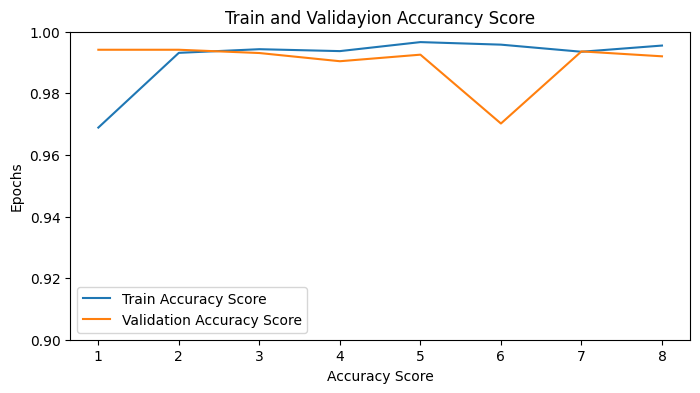

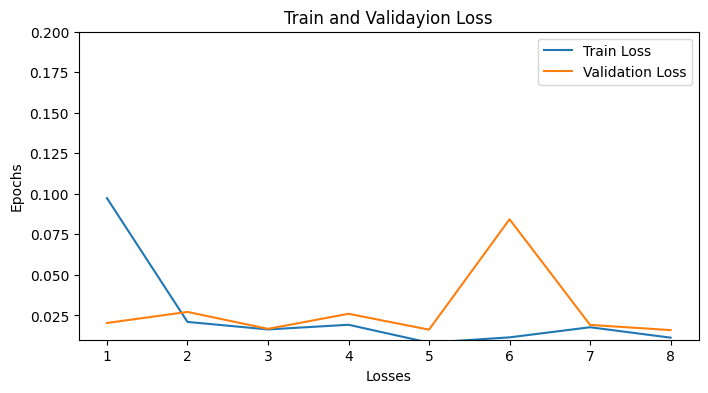

In [19]:
def plot(res):
    
    plt.figure(figsize = (8, 4))
    plt.plot(res["tr_acc"] , label = "Train Accuracy Score")
    plt.plot(res['val_acc'], label = "Validation Accuracy Score")
    plt.title("Train and Validayion Accurancy Score")
    plt.xlabel("Accuracy Score")
    plt.ylabel("Epochs")
    plt.xticks(np.arange(len(res["val_acc"])), [i for i in range(1, len(res["val_acc"])+1)])
    plt.legend()
    plt.ylim(0.9 ,1)
    plt.show()
    
    plt.figure(figsize = (8, 4))
    plt.plot(res["tr_loss"] , label = "Train Loss")
    plt.plot(res['val_loss'], label = "Validation Loss")
    plt.title("Train and Validayion Loss")
    plt.xlabel("Losses")
    plt.ylabel("Epochs")
    plt.xticks(np.arange(len(res["val_loss"])), [i for i in range(1, len(res["val_loss"])+1)])
    plt.legend()
    plt.ylim(0.01 ,0.2)
    
    plt.show()
    
plot(result)    

100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:35<00:00, 52.57it/s]


Accuracy of the model on the test dataset : 0.994


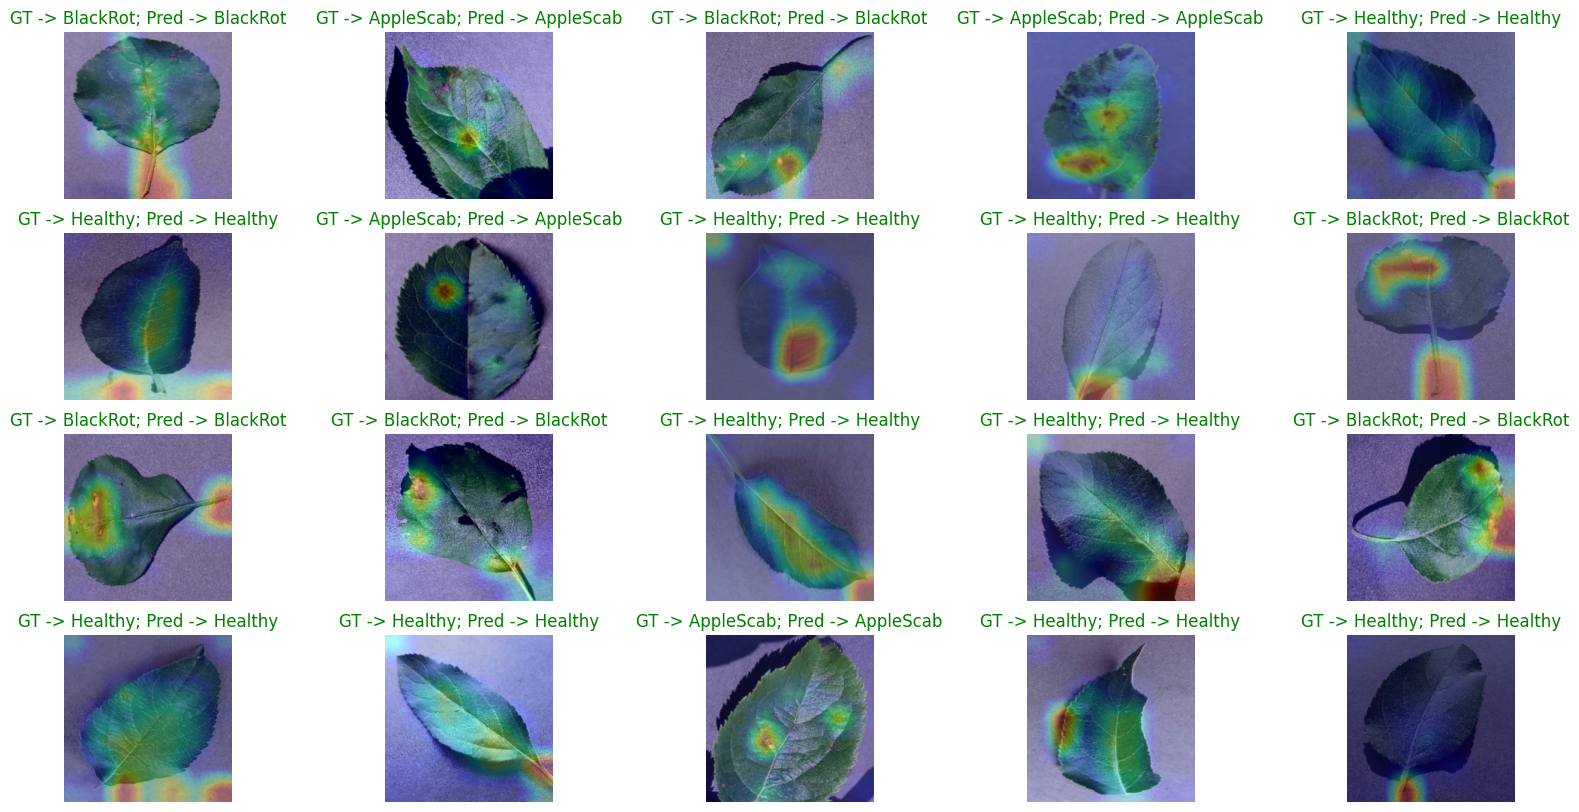

In [48]:
from tqdm import tqdm
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
def inference(model, device, ts_dl, num_ims, row, class_name = None, im_dim =None):
    accuracy = 0
    preds, ims, gts = [],[],[]
            
    for idx, batch in enumerate(tqdm(ts_dl)):
        # if idx==10 : break
        im, gt = batch
        im, gt = im.to(device), gt.to(device)
        
        pred = torch.argmax(model(im), dim =1)
        accuracy+=(pred==gt).sum().item()
        ims.append(im)
        gts.append(gt.item())
        preds.append(pred.item())
        
    print(f"Accuracy of the model on the test dataset : {(accuracy/len(ts_dl.dataset)):.3f}")
    plt.figure(figsize=(20,10))
    index = [random.randint(0, len(ims)-1) for _ in range(num_ims)]
    
    for i, idx in enumerate(index):
        # if i ==10: break
        im = ims[idx].squeeze()
        gt = gts[idx]
        pred = preds[idx]
    
        # GradCAM -> array 
        orginal_im = tr_2_im(im)/255
        cam = GradCAMPlusPlus(model=model, target_layers= [model.features[-1]])
        grayscale_cam = cam(input_tensor = im.unsqueeze(0))[0,:]
        heatmap = show_cam_on_image(img=orginal_im, mask = grayscale_cam, image_weight=0.1, use_rgb=True)
        
        # start plot
        plt.subplot(row, num_ims//row, i+1)
        plt.imshow(tr_2_im(im), cmap="gray")
        plt.axis("off")
        plt.imshow(cv2.resize(heatmap,(im_dim, im_dim), interpolation=cv2.INTER_LINEAR), alpha=0.3, cmap='jet')
        plt.axis("off")
        color = ("green" if {class_name[int(gt)]} == {class_name[int(pred)]} else "red")
        if class_name:
            plt.title(f"GT -> {class_name[gt]}; Pred -> {class_name[pred]}", color = color)
        else:
            plt.title(f"GT ->{tg}; Pred -> {pred}")
        
        
        
    

model = torch.load("Apple_best_mode/Applebest_model.pth")  
model.eval()
inference(model =model.to(device), device = device, ts_dl = ts_dl, num_ims = 20, row = 4, class_name = list(classes.keys()), im_dim = 224)